# <font color='tomato'>Unsupervised Learning in Satellite Imagery using Python</font>


https://github.com/conda-forge/rasterio-feedstock   
https://anaconda.org/conda-forge/earthpy   

    conda create -n geopandas -c conda-forge python=3.8 geopandas
    conda activate geopandas
    conda install -c conda-forge gdal
    conda install -c conda-forge earthpy 
    conda install -c conda-forge plotly 
    conda install -c conda-forge scikit-learn
    conda install -c anaconda tensorflow
    conda install -c conda-forge seaborn
    conda install ipykernel
    ipython kernel install --user --name=geopandas
    conda deactivate


# Import Modules

In [1]:
from glob import glob
import os
import numpy as np
from scipy.io import loadmat

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

import plotly.graph_objects as go

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
datapath = '..\Data\sundarbans_data'


# Read Data

In [3]:
datapath = '..\Data\sundarbans_data'
S_sentinel_bands = glob(os.path.join(datapath,'*B?*.tiff'))
S_sentinel_bands.sort()
S_sentinel_bands

['..\\Data\\sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B01_(Raw).tiff',
 '..\\Data\\sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B02_(Raw).tiff',
 '..\\Data\\sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B03_(Raw).tiff',
 '..\\Data\\sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B04_(Raw).tiff',
 '..\\Data\\sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B05_(Raw).tiff',
 '..\\Data\\sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B06_(Raw).tiff',
 '..\\Data\\sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B07_(Raw).tiff',
 '..\\Data\\sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B08_(Raw).tiff',
 '..\\Data\\sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B09_(Raw).tiff',
 '..\\Data\\sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B11_(Raw).tiff',
 '..\\Data\\sundarbans_data\\2020-01-27-00_00_2020

In [4]:
l = []
for i in S_sentinel_bands:
    with rio.open(i, 'r') as f:
        l.append(f.read(1))
arr_st = np.stack(l)

In [5]:
print(f'Height: {arr_st.shape[1]}\nWidth: {arr_st.shape[2]}\nBands: {arr_st.shape[0]}')

Height: 954
Width: 298
Bands: 12


# Visualize Data

## Bands

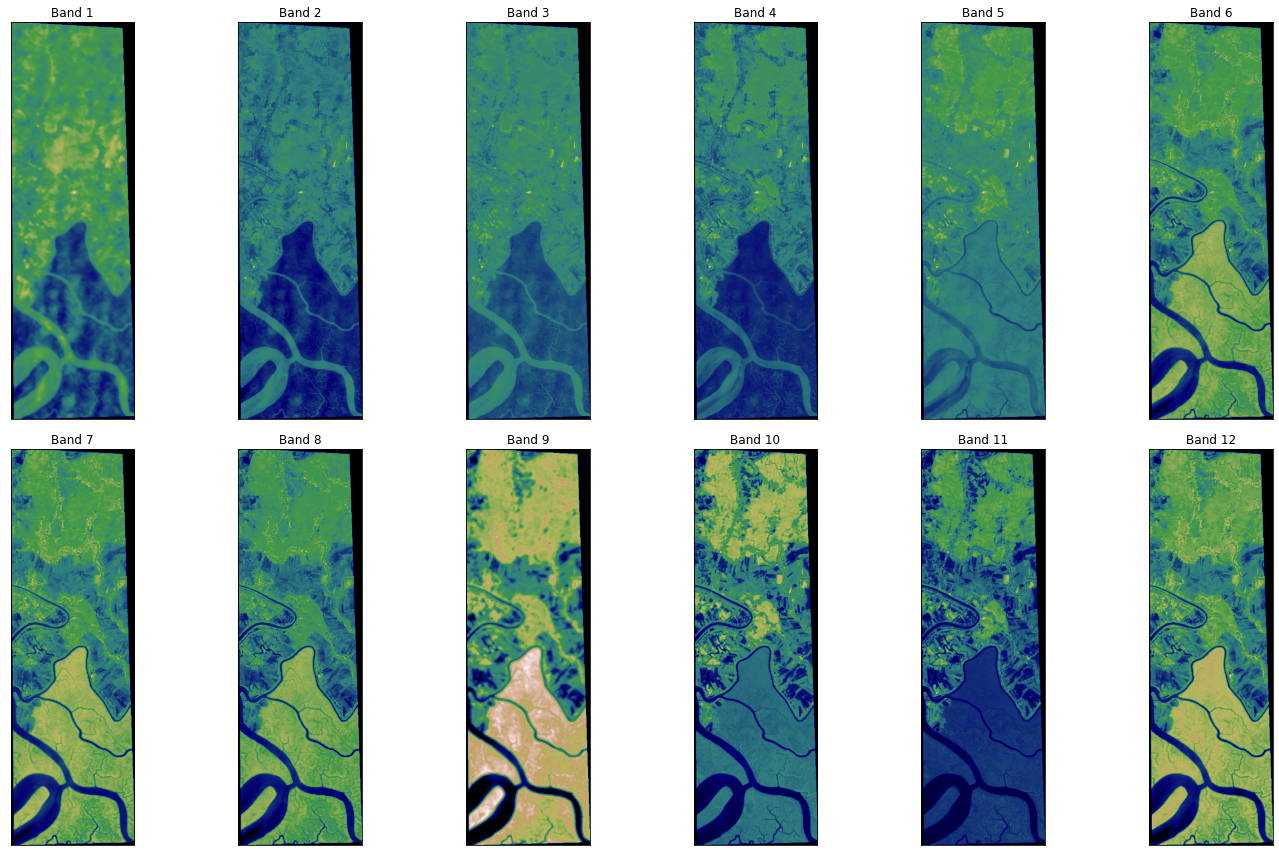

In [6]:
ep.plot_bands(arr_st, cmap = 'gist_earth', figsize = (20, 12), cols = 6, cbar = False)
plt.show()

## RGB Composite Image

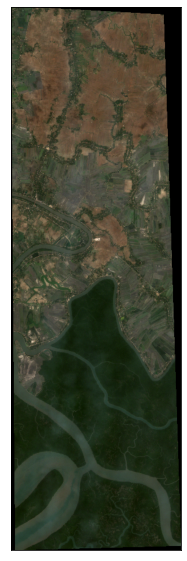

In [7]:
rgb = ep.plot_rgb(arr_st, 
                  rgb=(3,2,1), 
                  figsize=(8, 10), 
                  # title='RGB Composite Image'
                  )

plt.show()

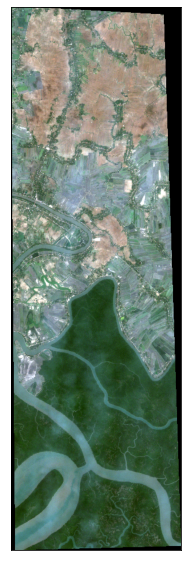

In [8]:
ep.plot_rgb(
    arr_st,
    rgb=(3, 2, 1),
    stretch=True,
    str_clip=0.2,
    figsize=(8, 10),
    # title="RGB Composite Image with Stretch Applied",
)

plt.show()

## Data Distribution of Bands

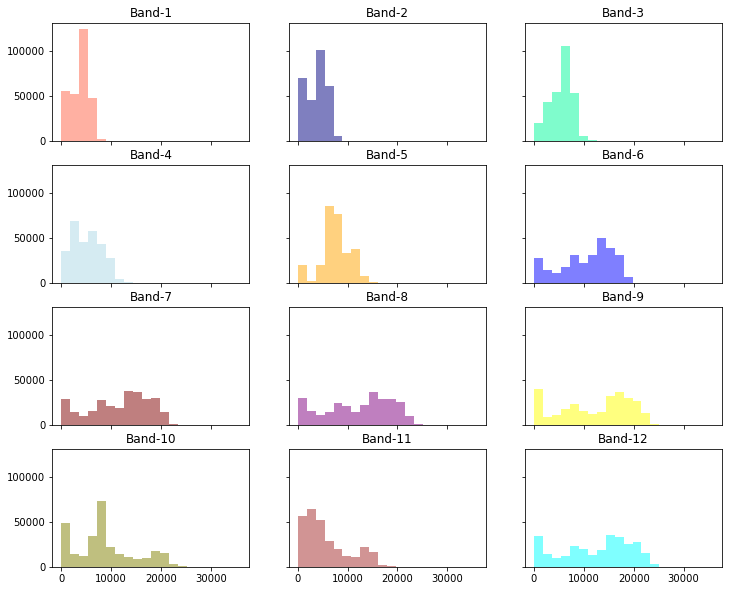

In [9]:
colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

ep.hist(arr_st, 
         colors = colors,
        title=[f'Band-{i}' for i in range(1, 13)], 
        cols=3, 
        alpha=0.5, 
        figsize = (12, 10)
        )

plt.show()

# Preprocessing 

In [10]:
x = np.moveaxis(arr_st, 0, -1)
x.shape

(954, 298, 12)

In [11]:
x.reshape(-1, 12).shape, 954*298

((284292, 12), 284292)

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_data = x.reshape(-1, 12)

scaler = StandardScaler().fit(X_data)

X_scaled = scaler.transform(X_data)

X_scaled.shape

(284292, 12)

## Principal Component Analysis (PCA)

In [13]:
pca = PCA(n_components = 4)

pca.fit(X_scaled)

data = pca.transform(X_scaled)

In [14]:
data.shape

(284292, 4)

In [15]:
pca.explained_variance_ratio_

array([0.55778198, 0.37521242, 0.0484222 , 0.00637526])

In [16]:
np.sum(pca.explained_variance_ratio_)

0.9877918653348995

## Visualize Bands after PCA

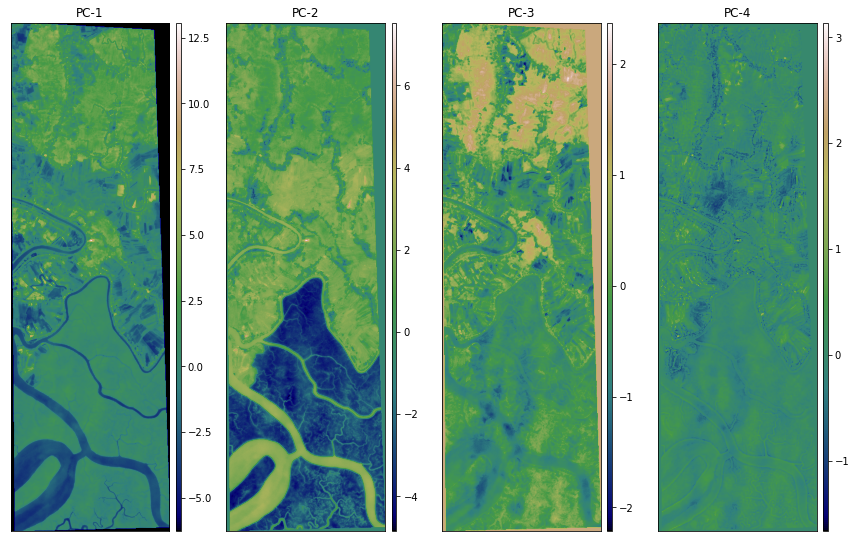

In [17]:
ep.plot_bands(np.moveaxis(data.reshape((954, 298, data.shape[1])), -1, 0),
              cmap = 'gist_earth',
              cols = 4,
              title = [f'PC-{i}' for i in range(1,5)])

plt.show()

# *k* - Means 

In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 6, random_state = 11)

kmeans.fit(data)


KMeans(n_clusters=6, random_state=11)

In [19]:
labels = kmeans.predict(data)

In [20]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5])

## Visualize Clusters

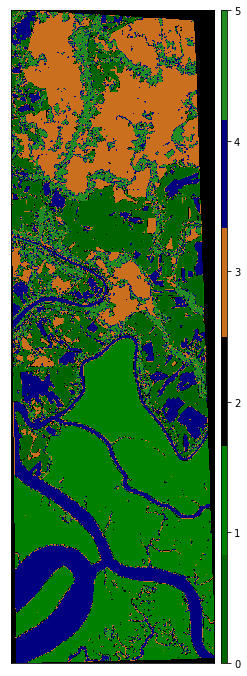

In [21]:
ep.plot_bands(labels.reshape(954, 298), cmap=ListedColormap(['darkgreen', 'green', 'black', '#CA6F1E', 'navy', 'forestgreen']))
plt.show()

Interactive plot using Plotly

In [22]:
if False:
    import plotly.express as px

    fig = px.imshow(labels.reshape(954, 298), 
              color_continuous_scale = ['darkgreen', 'green', 'black', '#CA6F1E', 'navy', 'forestgreen'])

    fig.update_xaxes(showticklabels=False)

    fig.update_yaxes(showticklabels=False)

    fig.update_layout(
        autosize=False,
        width=500,
        height=1000,
        margin=dict(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        ),
        # paper_bgcolor="LightSteelBlue",
    )

## Implementation of CNN for Land Cover Classification

Let's create three-dimensional patches of the Sundarbans satellite image by applying Principal Component Analysis (PCA) to the data. The below code is used to create functions for implementing PCA, creating 3D patches, and to split data into train and test data in the ratio of 70:30. After splitting the data the train and test labels are encoded using `to_categorical()` method from `tensorflow.keras` package

In [23]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels = False):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

from sklearn.model_selection import train_test_split

def splitTrainTestSet(X, y, testRatio, randomState=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test
  

## GLOBAL VARIABLES
dataset = 'SB'
test_size = 0.30
windowSize = 15
MODEL_NAME = 'Sundarbans'

datapath = '..\Data\sundarbans_data'

X_data = np.moveaxis(arr_st, 0, -1)
y_data = loadmat(os.path.join(datapath,'Sundarbands_gt.mat'))['gt']


# Apply PCA
K = 5
X,pca = applyPCA(X_data,numComponents=K)

print(f'Data After PCA: {X.shape}')

# Create 3D Patches
X, y = createImageCubes(X, y_data, windowSize=windowSize)
print(f'Patch size: {X.shape}')

# Split train and test
X_train, X_test, y_train, y_test = splitTrainTestSet(X, y, testRatio = test_size)

X_train = X_train.reshape(-1, windowSize, windowSize, K, 1)
X_test = X_test.reshape(-1, windowSize, windowSize, K, 1)

from tensorflow.keras.utils import to_categorical

# One Hot Encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(f'Train: {X_train.shape}\nTest: {X_test.shape}\nTrain Labels: {y_train.shape}\nTest Labels: {y_test.shape}')


Data After PCA: (954, 298, 5)
Patch size: (284292, 15, 15, 5)
Train: (199004, 15, 15, 5, 1)
Test: (85288, 15, 15, 5, 1)
Train Labels: (199004, 6)
Test Labels: (85288, 6)


## CNN Model

Let's build a three-dimensional CNN with different layers such as Convolution, Dropout, and Dense Layers. The below code is used to create a 3D-CNN for land cover classification using TensorFlow.

In [24]:
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten

S = windowSize
L = K
output_units = y_train.shape[1]

## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=16, kernel_size=(2, 2, 3), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=32, kernel_size=(2, 2, 3), activation='relu')(conv_layer1)
conv2d_shape = conv_layer2.shape
conv_layer3 = Reshape((conv2d_shape[1], conv2d_shape[2], conv2d_shape[3]*conv2d_shape[4]))(conv_layer2)
conv_layer4 = Conv2D(filters=64, kernel_size=(2,2), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(128, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(64, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
dense_layer3 = Dense(20, activation='relu')(dense_layer2)
dense_layer3 = Dropout(0.4)(dense_layer3)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer3)
# define the model with input layer and output layer
model = Model(name = dataset+'_Model' , inputs=input_layer, outputs=output_layer)

model.summary()

Model: "SB_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 15, 5, 1)]    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 14, 14, 3, 16)     208       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 13, 13, 1, 32)     6176      
_________________________________________________________________
reshape (Reshape)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 12, 12, 64)        8256      
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               117

As shown in the summary above, the 3D-CNN model has a total of 1,204,098 trainable parameters.

## Training

For training the defined DNN, I have used `Adam` optimizer, categorical cross-entropy, accuracy as a metric, and callbacks. A brief explanation of optimizer, loss, and callbacks used for training the 3D-CNN.

### Adam Optimizer

`Adam` is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based on training data. The advantages of using `adam` optimizer are:

- Straightforward to implement.
- Computationally efficient.
-  Little memory requirements.
- Invariant to diagonal rescale of the gradients.
- Well suited for problems that are large in terms of data and/or parameters.
- Appropriate for non-stationary objectives.
- Appropriate for problems with very noisy/or sparse gradients.
- Hyper-parameters have intuitive interpretation and typically require little tuning.

### Categorical Crossentropy

Cross-entropy is the default loss function to use for multi-class classification problems. In this case, it is intended for use with multi-class classification where the target values are in the set {0, 1, 3, …, n}, where each class is assigned a unique integer value. Mathematically, it is the preferred loss function under the inference framework of maximum likelihood. It is the loss function to be evaluated first and only changed if you have a good reason.

Cross-entropy will calculate a score that summarizes the average difference between the actual and predicted probability distributions for all classes in the problem. The score is minimized and a perfect cross-entropy value is 0. Cross-entropy can be specified as the loss function in Keras by specifying `categorical_crossentropy` when compiling the model.

### Callbacks

**EarlyStopping:** One technique to reduce overfitting in neural networks is to use early stopping. Early stopping prevents overtraining of your model by terminating the training process if it’s not really learning anything. This is pretty flexible — you can control what metric to monitor, how much it needs to change to be considered “still learning”, and how many epochs in a row it can falter before the model stops training.

**ModelCheckpoint:** This callback will save your model as a checkpoint file (in hdf5 or h5format) to disk after each successful epoch. You can actually set the output file to be dynamically named based on the epoch. You can also write either the loss value or accuracy value as part of the log’s file name.

**TensorBoard:** This callback logs after every batch of training to monitor your metrics, graphs, histograms, images, etc.

The below code is used to compile and train the model

In [25]:
# Compile
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# Callbacks
from datetime import datetime

logdir = os.path.join(datapath,'logs',model.name+'_'+datetime.now().strftime("%d:%m:%Y-%H:%M:%S"))
logdir = logdir.replace(':','_')
print(logdir)

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

tensorboard_callback = TensorBoard(log_dir=logdir)

es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 1,
                   verbose = 1,
                   restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'Pavia_University_Model.h5', 
                             monitor = 'val_loss', 
                             mode ='min', 
                             save_best_only = True,
                             verbose = 1)
# Fit
history = model.fit(x=X_train, y=y_train, 
                    batch_size=1024*6, epochs=6, 
                    validation_data=(X_test, y_test), callbacks = [tensorboard_callback, es, checkpoint])

..\Data\sundarbans_data\logs\SB_Model_22_03_2021-19_23_51
Epoch 1/6
 1/33 [..............................] - ETA: 0s - loss: 1.8091 - accuracy: 0.1310WARNING:tensorflow:From C:\Users\nwillers\Anaconda3\envs\geopandas\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
33/33 [==============================] - ETA: 0s - loss: 1.0518 - accuracy: 0.5766
Epoch 00001: val_loss improved from inf to 0.41691, saving model to Pavia_University_Model.h5
33/33 [==============================] - 30s 901ms/step - loss: 1.0518 - accuracy: 0.5766 - val_loss: 0.4169 - val_accuracy: 0.8722
Epoch 2/6
33/33 [==============================] - ETA: 0s - loss: 0.5371 - accuracy: 0.8037
Epoch 00002: val_loss improved from 0.41691 to 0.22919, saving model to Pavia_University_Model.h5
33/33 [==============================] - 30s 901ms

The code for the Accuracy and Loss graph during the training along with the output is shown below and the X-Axis represents epochs and Y-Axis represents the Percentage.

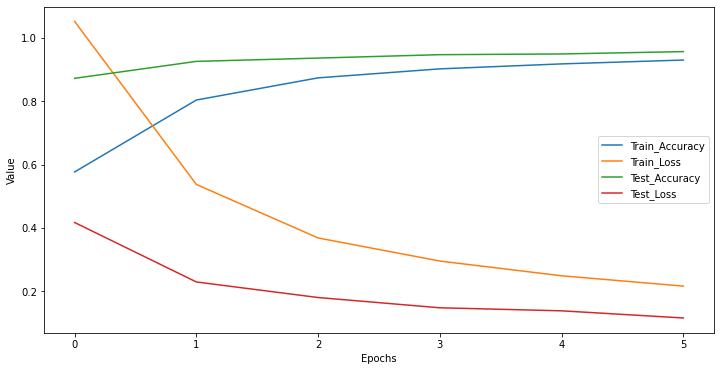

In [26]:
import pandas as pd
history = pd.DataFrame(history.history)

plt.figure(figsize = (12, 6))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

## Results

The CNN model after training has 96.00% accuracy, Let’s see the confusion matrix - A tabular representation often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

12/12 [==============================] - 3s 241ms/step


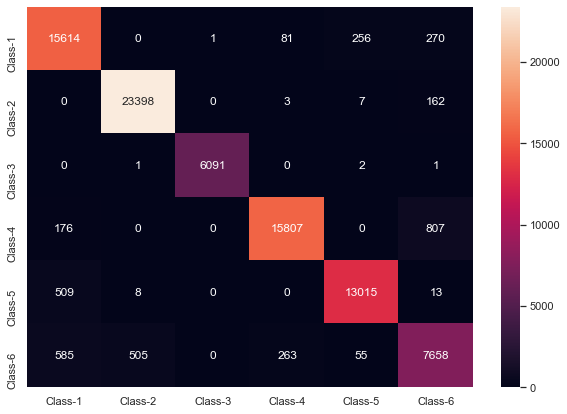

In [28]:
pred = model.predict(X_test, batch_size=1204*6, verbose=1)

plt.figure(figsize = (10,7))

classes = [f'Class-{i}' for i in range(1, 7)]

from tensorflow.math import confusion_matrix
import seaborn as sns; sns.set_theme()

mat = confusion_matrix(np.argmax(y_test, 1),
                            np.argmax(pred, 1))

df_cm = pd.DataFrame(mat.numpy(), index = classes, columns = classes)

sns.heatmap(df_cm, annot=True, fmt='d')

plt.show()

The classification report shows accuracy along with classwise precision, recall, f1-score, and Support. The output is shown below:

In [29]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, 1),
                            np.argmax(pred, 1),
      target_names = [f'Class-{i}' for i in range(1, 7)]))

              precision    recall  f1-score   support

     Class-1       0.92      0.96      0.94     16222
     Class-2       0.98      0.99      0.99     23570
     Class-3       1.00      1.00      1.00      6095
     Class-4       0.98      0.94      0.96     16790
     Class-5       0.98      0.96      0.97     13545
     Class-6       0.86      0.84      0.85      9066

    accuracy                           0.96     85288
   macro avg       0.95      0.95      0.95     85288
weighted avg       0.96      0.96      0.96     85288



Finally, let’s visualize the classification map of the Sundarbans satellite. The below code is used to create the classification map

40/40 [==============================] - 10s 262ms/step


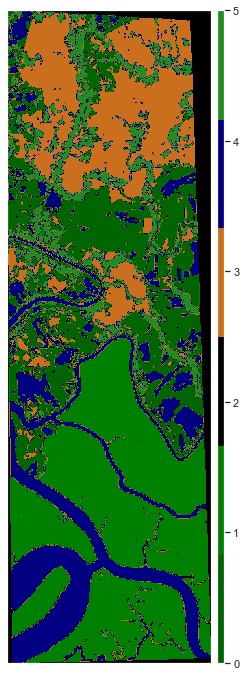

In [30]:
pred_t = model.predict(X.reshape(-1, windowSize, windowSize, K, 1),
                       batch_size=1204*6, verbose=1)
# Visualize Groundtruth

ep.plot_bands(np.argmax(pred_t, axis=1).reshape(954, 298), 
              cmap=ListedColormap(['darkgreen', 'green', 'black', 
                                   '#CA6F1E', 'navy', 'forestgreen']))
plt.show()

#  Conclusion

This article covers different Deep Learning methods that are used for land cover classification of satellite imagery and it also shows the implementation and training of 3D-CNN for land cover classification of Sundarbans satellite imagery.


# Citations
1. https://www.usgs.gov/faqs/what-remote-sensing-and-what-it-used?qt-news_science_products=0#qt-news_science_products
1.  https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2?qt-science_center_objects=0#qt-science_center_objects
1.  https://www.kdnuggets.com/2015/01/deep-learning-explanation-what-how-why.html
1.  https://wiki.aalto.fi/display/ITSP/Neural+networks
1.  https://cs231n.github.io/convolutional-networks/#:~:text=Convolutional%20Neural%20Networks%20are%20very,have%20learnable%20weights%20and%20biases.
1.  https://wiki.tum.de/display/lfdv/Layers+of+a+Convolutional+Neural+Network
1.  https://whc.unesco.org/en/list/798/
